# AZURE ML designer
## 1 -creation données brutes en CSV (500 lignes)

In [2]:
import pandas as pd
import time

start = time.time()
data = pd.read_csv('input/sentiment140/training.1600000.processed.noemoticon.csv', delimiter = ',', header=None)
print(time.time()-start)
print('le fichier contient ', len(data.index),'lignes' )
data.columns=['target','id','date','flag','user','text']
display(data)

2.8633785247802734
le fichier contient  1600000 lignes


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
#melange
data0_shuffled=data.loc[data.target==0,:].sample(frac=1).reset_index(drop=True)
data4_shuffled=data.loc[data.target==4,:].sample(frac=1).reset_index(drop=True)

data_0_sample=data0_shuffled.iloc[0:250].copy()
data_4_sample=data4_shuffled.iloc[0:250].copy()

result = pd.concat([data_0_sample,data_4_sample])
result['cible']=result['target'].map({0:0,4:1})
result=result.sample(frac=1).reset_index(drop=True)

res=result.loc[:,['cible','text']].copy()
display(res)

res.to_csv('./data2AMLD500.csv', index=False)

,cible,text
0,0,@BluebirdQueen It is a really nice sunday aww x
1,1,"@scrappergirl106 Don't feel bad, I'm up, too ..."
2,1,Wow The Hangover was hilarious! Nonstop laughs.
3,0,OMG Next Friday is our prom... Miss my class a...
4,0,Good bye my delicious bread
...,...,...
495,0,Back from sleepover! Fun night! Lots of homewo...
496,0,"@hannahnicklin Oh well, we shall have to meet..."
497,0,Fuck fuck fuck fuck never never i fucking hate...
498,1,"Today has been long and tiring, but I've a smi..."


## AZURE ML SDK

In [1]:
import azureml.core
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.38.0


## 2- connexion au workspace

In [1]:
from azureml.core import Workspace

#connection avec authentification 
#fichier config recuperé sur le portail et stocké dans P7
ws = Workspace.from_config()
print("workspace",ws.name, "loaded")

#recuperaton des cibles de calcul par exemple 
#grace à l'attribut compute_targets de la classe workspace
print("Compute Resources:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("instance existance:", compute.name, ":", compute.type)

workspace nab-ML loaded
Compute Resources:
instance existance: P7-CPU : ComputeInstance


## 3-  recupération du datastore de defaut lié au workspace

In [75]:
# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)

azureml_globaldatasets - Default = False
workspacefilestore - Default = False
workspaceworkingdirectory - Default = False
workspaceartifactstore - Default = False
workspaceblobstore - Default = True


## 4-  Upload des fichiers CSV vers datastore
* on passe par la methode upload_directory disponible qu 'avec le dataset.File et non le dataset.Tabular
* les methodes from_file ne fonctionnent que pour une url ou dans le datastore

In [90]:
#Upload data to a datastore
#Now that you have determined the available datastores, you can upload files from your local file system to a datastore 
#so that it will be accessible to experiments running in the workspace, regardless of where the experiment script is actually being run.

In [96]:
from azureml.core import Dataset, Datastore


target_path='P7/'

#upload_directory(src_dir, target, pattern=None, overwrite=False, show_progress=True)
#sentiment
Dataset.File.upload_directory('./input/sentiment140/', (default_ds, target_path), pattern='*.csv', overwrite=True, show_progress=True)

Validating arguments.
Arguments validated.
Uploading file to P7/
Filtering files with pattern matching *.csv
Uploading an estimated of 1 files
Uploading ./input/sentiment140/training.1600000.processed.noemoticon.csv
Uploaded ./input/sentiment140/training.1600000.processed.noemoticon.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', 'P7/')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

In [97]:
#word embedding
Dataset.File.upload_directory('./embedding/glove.6B/', (default_ds, target_path), pattern='*50d.txt', overwrite=True, show_progress=True)

#depreciated
#depreciated default_ds.upload_files(files=['./input/sentiment140/training.1600000.processed.noemoticon.csv'], # Upload 
#depreciated                       target_path='P7/', # Put it in a folder path in the datastore
#depreciated                       overwrite=True, # Replace existing files of the same name
#depreciated                       show_progress=True)

Validating arguments.
Arguments validated.
Uploading file to P7/
Filtering files with pattern matching *50d.txt
Uploading an estimated of 1 files
Uploading ./embedding/glove.6B/glove.6B.50d.txt
Uploaded ./embedding/glove.6B/glove.6B.50d.txt, 1 files out of an estimated total of 1
Uploaded 1 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', 'P7/')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

## 5-a Passer le file sentiment en tabular dataset

In [98]:
from azureml.core import Dataset

#Create a tabular dataset from the path on the datastore (this may take a short while)
tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'P7/*.csv'),header=False, separator=',', support_multi_line=True, encoding='latin1')
#'latin1' pour eviter le sproblèmes avec 'utf8'
#« UTF8 », « iso88591 », « latin1 », « ASCII », « UTF16 », « UTF32 », « utf8bom » et « Windows1252

# Display the first 10 rows as a Pandas dataframe
tab_data_set.take(10).to_pandas_dataframe(on_error='null', out_of_range_datetime='null')


,Column1,Column2,Column3,Column4,Column5,Column6
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


## 5-b passer le file WE glove 50d en file dataset

In [99]:
from azureml.core import Dataset

#Create a filedataset from the path on the datastore (this may take a short while)
fil_data_set = Dataset.File.from_files(path=(default_ds, 'P7/*.txt'))


## 6- Register dataset
* on inscrit le dataset pour qu il puisse etre utilisé par des experiences du workspace

In [100]:
# Register the tabular dataset
try:
    tab_data_set = tab_data_set.register(workspace=ws, 
                                        name='sentiment dataset',
                                        description='sentiment data',
                                        tags = {'format':'CSV'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)
    
    
# Register the file dataset
try:
    fil_data_set = fil_data_set.register(workspace=ws, 
                                        name='glove50d dataset',
                                        description='glove 50d word emb data',
                                        tags = {'format':'txt'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)

* liste des datasets inscrits dans le workspace nab-ML

In [101]:
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

Datasets:
	 glove50d dataset version 1
	 sentiment dataset version 1
	 P7_sent_ultralight version 1
	 P7_sent_light version 1


In [9]:
import time
from azureml.core import Dataset
dataset=Dataset.get_by_name(ws, 'sentiment dataset')
start = time.time()
data=dataset.to_pandas_dataframe(on_error='null', out_of_range_datetime='null')
print(time.time()-start)

281.4914824962616


In [10]:
data

,Column1,Column2,Column3,Column4,Column5,Column6
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## 7-preprocessing  CLEANING / LEMMATIZATION / STEMMING

In [11]:
#https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/
#https://towardsdatascience.com/text-normalization-with-spacy-and-nltk-1302ff430119

import regex as re #module regex
import nltk
import string
from nltk.stem import WordNetLemmatizer
#tous les dictionnaires: https://www.nltk.org/nltk_data/
from nltk.corpus import words


 #DL des stopwords NLTK
#nltk.download('stopwords')
 #DL des punctuations NLTK
#nltk.download('punkt')
 #DL du dictionnaire de mots anglais NTLK
#nltk.download('words')
 #DL pour la lemmatization
#nltk.download('wordnet')


#stopwords anglais
#attention les stopwords n'est pas une liste absolue
stopwords = nltk.corpus.stopwords.words('english')
more_stopwords = ['us', 'im', 'c', "youd", "hadnt", 
                  "hasnt", "havent", "isnt","might", "mightnt", "mustnt", "neednt", 
                  "shant", "shouldnt", "wasnt", "werent", "wont", "wouldnt",
                  "youre","yourent", "youve", "youvent", "youll", "shes","shesnt" "thatll",
                  'cant','wont',"dont", "shouldve",'aint',"arent","couldnt","didnt", "doesnt","thats","shoulda"]
stopwords = stopwords + more_stopwords


#mots anglais du dictionnaire NLTK
#tous les dictionnaires: https://www.nltk.org/nltk_data/
#set() permet d'avoir un mot unique
words = set(nltk.corpus.words.words())
#words = set(nltk.corpus.brown.words())

wnl = WordNetLemmatizer()

def Preprocess_npl(listofdoc):
    '''cleaning + lemmatization
    sub=substitute'''
    preprocess_list_1 = []
    preprocess_list_2 = []
    preprocess_list_3 = []
    for doc in listofdoc :
        #remove text in square brackets: .(any caracter) * (0 or more times) ?\] (0 or 1 time ']')
        doc = re.sub('\[.*?\]', '', doc)
        #remove links
        doc = re.sub('https?://\S+|www\.\S+', '', doc)
        doc = re.sub('http?://\S+|www\.\S+', '', doc)
        ##remove text in angle brackets
        doc = re.sub('<.*?>+', '', doc)
        #remove punctuation
        #!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
        #doc = re.sub('[%s]' % re.escape(string.punctuation), '', doc)
        #remove back line
        doc = re.sub('\n', '', doc)
        #word cracter digit word caracter
        #doc = re.sub('\w*\d\w*', '', doc)
        #remove special carcter comme  ♫
        doc = re.sub('\p{S}', '', doc)
    
        #la fonction join permet de creer un separateur
        #lowercase & remove punctuation : example: Don't->dont
        doc_wo_punct = "".join([i.lower() for i in doc if i not in string.punctuation])
        #remove number
        doc_wo_num = ''.join(i for i in doc_wo_punct if not i.isdigit())
        #tokenization
        token_doc = nltk.tokenize.word_tokenize(doc_wo_num)
        #remove stopwords
        words_wo_stopwords = [w for w in token_doc if w not in stopwords]
        
        #lemmatization
        #attention ici on cree un generateur et non une liste: (wnl.lemmatize(w) for w in words_wo_stopwords) different de [wnl.lemmatize(w) for w in words_wo_stopwords]
        #la difference et qu on recupere à la demande
        #https://stackoverflow.com/questions/47789/generator-expressions-vs-list-comprehensions
        words_lemmatize = [wnl.lemmatize(w) for w in words_wo_stopwords]
        
        #on ne retourne que les mots appartenant au dictionnaire words  et ne possédant pas autre chose que des carcatère de l'alphabet
        doc_clean_1 = ' '.join(w for w in words_wo_stopwords )
        doc_clean_2 = ' '.join(w for w in words_lemmatize)
        doc_clean_3 = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())
        
        preprocess_list_1.append(doc_clean_1)
        preprocess_list_2.append(doc_clean_2)
        preprocess_list_3.append(doc_clean_3)
    return preprocess_list_1, preprocess_list_2, preprocess_list_3


start = time.time()
data.columns=['target','id','date','flag','user','text']
data['text_sw'],data['text_swlem'],data['text_swlemdic'] =Preprocess_npl(data.text)
print(time.time()-start)

276.4624447822571


In [12]:
#https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg
from nltk.stem.porter import PorterStemmer #less aggressive
from nltk.stem.snowball import SnowballStemmer #kind of Porter2 (probably first choice) :0.78sec pour 1000
from nltk.stem.lancaster import LancasterStemmer #most aggressive
from nltk.stem import WordNetLemmatizer #fast
#nltk.download('wordnet')

def stemm_data(data,colin,colout,typ,algo):
    '''type: stemmer/lemmatizer
        stemmer algo: 
            nltk.PorterStemmer()
            nltk.SnowballStemmer("english")
            nltk.LancasterStemmer()
        lemme algo:
            nltk.WordNetLemmatizer()
            '''
    if typ=='stemmer':
        stemmer = algo
        def stemm_text(text):
            text = ' '.join(stemmer.stem(word) for word in text.split(' '))
            return text
    elif typ=='lemmatizer':
        lemmatizer = algo
        def stemm_text(text):
            text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
            return text
        
    data[colout] = data[colin].apply(stemm_text)
    return data


#start = time.time()
#revfilt=stemm_data(data=revfilt,colin='text4',colout='lemm',typ='lemmatizer',algo=nltk.WordNetLemmatizer())
#print(time.time()-start)

start = time.time()
data=stemm_data(data=data,colin='text_swlemdic',colout='text_stemm',typ='stemmer',algo=nltk.SnowballStemmer("english"))
print(time.time()-start)

88.36992263793945


In [55]:
data

,target,id,date,flag,user,text,text_sw,text_swlem,text_swlemdic,text_stemm
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer got david carr third day,switchfoot awww bummer got david carr third day,bummer got carr third day,bummer got carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting cry result schoo...,upset update facebook texting cry result schoo...,upset update cry result school today also blah,upset updat cri result school today also blah
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save re...,kenichan dived many time ball managed save res...,many time ball save rest go bound,mani time ball save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,whole body feel itchy like fire,whole body feel itchy like fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see,nationwideclass behaving mad see,mad see,mad see
...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,woke school best feeling ever,woke school best feeling ever,woke school best feeling ever,woke school best feel ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interviews â «,thewdbcom cool hear old walt interview â «,cool hear old walt interview «,cool hear old walt interview «
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details,ready mojo makeover ask detail,ready mojo ask detail,readi mojo ask detail
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,happy th birthday boo alll time tupac amaru sh...,happy th birthday boo time,happi th birthday boo time


## 8-keras tokenization -> dictionnaire -> sequence -> padding

In [63]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

start = time.time()
#initialisation de la tokenization avec les 2500 mots les plus fréquents
#ca ne change pas la taille du dictionnaire mais ca impacte le nombre de colonne de X
#2500 ca fait dansnotre cas des sequences de 25 mots
#None donne des sequences de 52 mots

tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')

#update du dictionnaire de vocabulaire de tokenization #obligatoire
tokenizer.fit_on_texts(data['text_swlemdic'].values)
#taille du dictionnaire
vocab_size = len(tokenizer.word_index) + 1

#transformation des docs en sequences d'entiers correpondant à un mot
X = tokenizer.texts_to_sequences(data['text_swlemdic'].values)

#padding des sequences de facons à ce qu'elles fassent toute la même taille
#par defaut pad en pre (debut de sequence) mais on peut le mettre en post (fin de sequence)
X = pad_sequences(X)
print(vocab_size)
print(time.time()-start)
print (X.shape)

40222
27.48770260810852
(1600000, 25)


## 9- chargement des modèles préentrainés

In [64]:
#on telecharge le dataset
finput = Dataset.get_by_name(ws, 'glove50d dataset')
loc=finput.download(target_path=None, overwrite=False, ignore_not_found=False)

In [67]:
from gensim.models import KeyedVectors #pour lecture word emb

#glove
start = time.time()
#glove50d = KeyedVectors.load_word2vec_format('embedding/glove.6B/glove.6B.50d.txt', binary=False, no_header=True)
glove50d = KeyedVectors.load_word2vec_format(loc[0], binary=False, no_header=True)
print(time.time()-start)

10.373645782470703


In [68]:
import numpy as np
# create a weight matrix for words in training docs
def we2matrix(tokenizer, we_kv, we_dim, normalization=False):
    start = time.time()
    #taille du vocabulaire du keras tokenizer fitté sur nos datas
    vocab_size = len(tokenizer.word_index) + 1
    #initialisation de la matrice à 0
    embedding_matrix = np.zeros((vocab_size, we_dim))
    #compteur de mot non matché
    count_nm=0
    
    #recuperation des vecteurs pour le dictionnaire du keras tokenizer fitté sur nos datas
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = we_kv.get_vector(word, norm=normalization)
        except:
            count_nm=count_nm+1
            #on passe à la prochaine iteration de la boucle
            continue
        #on modifie la matrice que si on a un terme sinon ca reste à 0
        embedding_matrix[i] = embedding_vector
            
    #pourcentage final de mots non matchés       
    nm=count_nm/vocab_size
    print(time.time()-start)
    print('pct non matché:', "{:.2f}".format(nm))
    return embedding_matrix

glove50d_matrix=we2matrix(tokenizer, glove50d, 50, normalization=False)

0.06283998489379883
pct non matché: 0.27


## 10 - split train/test

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split

#creation des dummies pour le label/target
Y = pd.get_dummies(data['target']).values

#split 1.6M->1000 :test_size = 0.0006263
X1, X2, y1, y2 = train_test_split(X,Y, test_size = 0.0006263, random_state = 36, stratify=Y)

#split train / test sur les 10000
X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size = 0.2, random_state = 36, stratify=y2)

## 11- sauvegarde en binaries des dataset necessaires

In [81]:
#on serialize en binaries
import os
from joblib import dump, load

folder = './input/joblib'
#creation du folder
try:
    os.mkdir(folder)
except FileExistsError:
    pass


dump(X_train,os.path.join(folder, 'X_train.joblib'))
dump(X_test,os.path.join(folder, 'X_test.joblib'))
dump(y_train,os.path.join(folder, 'y_train.joblib'))
dump(y_test,os.path.join(folder, 'y_test.joblib'))
dump(glove50d_matrix,os.path.join(folder, 'glove50d_matrix.joblib'))


['./input/joblib\\glove50d_matrix.joblib']

## 12-upload des binaries vers le datastore du workspace

In [82]:
target_path='P7/train_input/'
Dataset.File.upload_directory('./input/joblib/', (default_ds, target_path), pattern='*.joblib', overwrite=True, show_progress=True)

Validating arguments.
Arguments validated.
Uploading file to P7/train_input/
Filtering files with pattern matching *.joblib
Uploading an estimated of 5 files
Uploading ./input/joblib/X_test.joblib
Uploaded ./input/joblib/X_test.joblib, 1 files out of an estimated total of 5
Uploading ./input/joblib/X_train.joblib
Uploaded ./input/joblib/X_train.joblib, 2 files out of an estimated total of 5
Uploading ./input/joblib/y_test.joblib
Uploaded ./input/joblib/y_test.joblib, 3 files out of an estimated total of 5
Uploading ./input/joblib/y_train.joblib
Uploaded ./input/joblib/y_train.joblib, 4 files out of an estimated total of 5
Uploading ./input/joblib/glove50d_matrix.joblib
Uploaded ./input/joblib/glove50d_matrix.joblib, 5 files out of an estimated total of 5
Uploaded 5 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', 'P7/train_input/')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

## 13- chargement des inputs d'entrainement dans le blobstore et registration

In [84]:
from azureml.core import Dataset
#Create a filedataset from the path on the datastore (this may take a short while)
fil_data_set_1 = Dataset.File.from_files(path=(default_ds, 'P7/train_input/X_train.joblib'))
fil_data_set_2 = Dataset.File.from_files(path=(default_ds, 'P7/train_input/X_test.joblib'))
fil_data_set_3 = Dataset.File.from_files(path=(default_ds, 'P7/train_input/y_train.joblib'))
fil_data_set_4 = Dataset.File.from_files(path=(default_ds, 'P7/train_input/y_test.joblib'))
fil_data_set_5 = Dataset.File.from_files(path=(default_ds, 'P7/train_input/glove50d_matrix.joblib'))


# Register the file dataset
try:
    fil_data_set = fil_data_set_1.register(workspace=ws, 
                                        name='X_train.joblib',
                                        description='LSTM small X_train',
                                        tags = {'format':'joblib'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)
try:
    fil_data_set = fil_data_set_2.register(workspace=ws, 
                                        name='X_test.joblib',
                                        description='LSTM small X_test',
                                        tags = {'format':'joblib'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)
try:
    fil_data_set = fil_data_set_3.register(workspace=ws, 
                                        name='y_train.joblib',
                                        description='LSTM small y_train',
                                        tags = {'format':'joblib'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)
try:
    fil_data_set = fil_data_set_4.register(workspace=ws, 
                                        name='y_test.joblib',
                                        description='LSTM small y_test',
                                        tags = {'format':'joblib'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)
try:
    fil_data_set = fil_data_set_5.register(workspace=ws, 
                                        name='glove50d_matrix.joblib',
                                        description='LSTM glove50d dico matrix',
                                        tags = {'format':'joblib'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)

## 14- creation d'une cible de calcul

In [94]:
from azureml.core import Workspace
#pour gerer les clusters
from azureml.core.compute import AmlCompute
#pour gerer une instance managéee dans ML
#gère un environnement de développement ML optimisé basé sur le cloud dans Azure Machine Learning.
from azureml.core.compute import ComputeInstance

from azureml.core.compute import ComputeTarget

# Load the workspace from the saved config file
ws = Workspace.from_config()

# Specify a name for the compute (unique within the workspace)
compute_name = 'P7-CPU'

# Define compute configuration
#cluster comportant jusqu’à quatre nœuds basé sur l’image de machine virtuelle STANDARD_DS12_v2 
# La priorité des machines virtuelles (VM) est définie sur Dedicated
# l’alternative consiste à spécifier lowpriority, qui a un coût inférieur mais signifie que les machines virtuelles peuvent être préemptées 
#si une charge de travail d’une priorité plus élevée a besoin du calcul
compute_config = ComputeInstance.provisioning_configuration(vm_size='Standard_DS3_v2')

# Create the compute
#Cette méthode crée une cible de calcul plutôt que d’en attacher une existante
P7_cpu = ComputeTarget.create(ws, compute_name, compute_config)
P7_cpu.wait_for_completion(show_output=True)


Creating.......................................................................
Running


In [96]:
#stop la becane
P7_cpu.stop()

In [ ]:
#efface la becane
P7_cpu.delete()

In [95]:
#demarrer la becane
P7_cpu.start()

### environnement
* encapsulation of the environment where your machine learning training happens
* Python packages, Docker image, environment variables, and software settings around your training and scoring scripts
* They also specify runtimes (Python, Spark, or Docker)
* You can either define your own environment, or use an Azure ML curated environment, These environments are backed by cached Docker images which reduces the run preparation cost

In [4]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [107]:
import joblib
joblib.__version__

'1.0.1'

## 15- creation d'un script run configuration

### a- Create a training folder

In [10]:
import os, shutil
from azureml.core import Dataset

# Create a folder for the experiment files
training_folder = 'P7-training'
os.makedirs(training_folder, exist_ok=True)

#on telecharge le dataset
loc=Dataset.get_by_name(ws, 'glove50d_matrix.joblib').download(target_path=training_folder, overwrite=True, ignore_not_found=False)
loc=Dataset.get_by_name(ws, 'y_test.joblib').download(target_path=training_folder, overwrite=True, ignore_not_found=False)
loc=Dataset.get_by_name(ws, 'y_train.joblib').download(target_path=training_folder, overwrite=True, ignore_not_found=False)
loc=Dataset.get_by_name(ws, 'X_test.joblib').download(target_path=training_folder, overwrite=True, ignore_not_found=False)
loc=Dataset.get_by_name(ws, 'X_train.joblib').download(target_path=training_folder, overwrite=True, ignore_not_found=False)

# Copy the data file into the experiment folder
#shutil.copy('data/diabetes.csv', os.path.join(training_folder, "diabetes.csv"))

### b- Create and writing a training script

In [47]:
%%writefile $training_folder/train.py

import os
from azureml.core import Run
# Get the experiment run context
run = Run.get_context()

#recuperation des data
from joblib import dump, load


glove50d_matrix = load('glove50d_matrix.joblib', mmap_mode='r')
y_test = load('y_test.joblib', mmap_mode='r')
X_test = load('X_test.joblib', mmap_mode='r')
y_train = load('y_train.joblib', mmap_mode='r')
X_train = load('X_train.joblib', mmap_mode='r')

######################

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras import backend

#clear keras session
backend.clear_session()


#taille du vocabulaire /dim du we/ we matrix
vocab_size=glove50d_matrix.shape[0]
embed_dim=50
embedding_matrix=glove50d_matrix

#taille du vecteur de sortie / nb de neurones
lstm_out=50

# define model
model1 = Sequential()
# couche embedding non entrainable
#pas besoin de faire de drop out de regularisation a ce niveau la car on c'est deja pré-entrainé
model1.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=X_train.shape[1], trainable=False))

#ajout d'une couche LSTM (mémoire) avec regularisation dropout
model1.add(LSTM(lstm_out))#, dropout=0.1, recurrent_dropout=0.1))
#fully connected de sortie 2D
model1.add(Dense(2,activation='softmax'))
#complilation
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# summarize the model
print('model1',model1.summary())


from keras import callbacks
callback1=callbacks.EarlyStopping(monitor="val_loss",patience=5,mode="auto",restore_best_weights=True)



#Here we train the Network.
print('Training a LSTM neural network')
batch_size= 32


model_info_1=model1.fit(X_train, y_train, batch_size =batch_size,validation_split=0.2, epochs = 50, callbacks=[callback1],  verbose = 2)
print(model_info_1.history.keys())
      
      
# Save the trained model in the outputs folder
os.makedirs('outputs', exist_ok=True)
dump(value=model_info_1.history, filename='outputs/model_info_1.history.joblib')


      
      
run.complete()

Overwriting P7-training/train.py


## 16-a run the training locally with azure ML

* environnement
    * encapsulation of the environment where your machine learning training happens
    * Python packages, Docker image, environment variables, and software settings around your training and scoring scripts
    * They also specify runtimes (Python, Spark, or Docker)
    * You can either define your own environment, or use an Azure ML curated environment, These environments are backed by cached Docker images which reduces the run preparation cost

In [134]:
from azureml.core import Experiment, ScriptRunConfig, Environment
#from azureml.widgets import RunDetails

from azureml.core import Workspace, Environment

ws = Workspace.from_config()


#env = Environment.get(workspace=ws, name="AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu")
#si en local on prend l'environnement local
env = Environment("user-managed-env")
env.python.user_managed_dependencies = True

# Create a Python environment for the experiment (from a .yml file)
#env = Environment.from_conda_specification("experiment_env", "environment.yml")

# Create a script config
from azureml.core import ScriptRunConfig

# compute_target=my_compute_target sur le cloud /  compute_target='local' en local
script_config = ScriptRunConfig(source_directory=training_folder,
                      script='train.py',
                      compute_target='local',
                      environment=env)

# Set compute target
# Skip this if you are running on your local computer
#script_run_config.run_config.target = my_compute_target

from azureml.core import Experiment

# submit the experiment run
experiment_name = 'lstm-train'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)

# Show the running experiment run in the notebook widget
#RunDetails(run).show()

# Block until the experiment run has completed
run.wait_for_completion()

{'runId': 'lstm-train_1645566973_f3d523f6',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2022-02-22T21:56:15.742017Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'bc56cd2b-2fb6-4951-9a01-f5c92bc4eb6f'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'user-managed-env',
   'version': 'Autosave_2022-02-22T10:43:38Z_38287da1',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': True,
    'condaDependencies': {'channels': [

In [1]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core import Workspace, Environment
from azureml.core.compute import ComputeTarget

ws = Workspace.from_config()
compute_name = 'P7-cpu'
ComputeTarget(workspace=ws, name=compute_name).start()

## 17-a creation et registration d'un custom environment
* probleme : obligé d'ajouter le pip joblib dans le dockerfile de l environnement dans l interface
    * le conda_dep.add_pip_package("joblib==1.0.1") ne semble rien apporter

In [ ]:
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments#use-a-curated-environment

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment.get(workspace=ws, name="AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu")
curated_clone = env.clone("customize_curated")

In [ ]:
# Installs numpy version 1.17.0 conda package
#conda_dep.add_conda_package("joblib")
conda_dep = CondaDependencies()
# Installs pillow package
conda_dep.add_pip_package("joblib==1.0.1")

# Adds dependencies to PythonSection of myenv
curated_clone.python.conda_dependencies=conda_dep

In [7]:
curated_clone.register(workspace=ws)

## 17-b run the training sur une instance du cloud with azure ML

In [129]:
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments#use-a-curated-environment

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
#si en local on prend l'environnement local
#env = Environment("user-managed-env")
#env.python.user_managed_dependencies = True

# Create a Python environment for the experiment (from a .yml file)
#env = Environment.from_conda_specification("experiment_env", "environment.yml")

env = Environment.get(workspace=ws, name="customize_curated")
# Create a script config
from azureml.core import ScriptRunConfig

# compute_target=my_compute_target sur le cloud /  compute_target='local' en local
script_config = ScriptRunConfig(source_directory=training_folder,
                      script='train.py',
                      compute_target=ComputeTarget(workspace=ws, name=compute_name),
                      environment=env)

# Set compute target
# Skip this if you are running on your local computer
#script_run_config.run_config.target = ComputeTarget(workspace=ws, name=compute_name)

from azureml.core import Experiment

# submit the experiment run
experiment_name = 'lstm-train'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)

# Show the running experiment run in the notebook widget
#RunDetails(run).show()

# Block until the experiment run has completed
run.wait_for_completion()

{'runId': 'lstm-train_1645565607_a07b442f',
 'target': 'P7-CPU',
 'status': 'Finalizing',
 'startTimeUtc': '2022-02-22T21:47:55.495189Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'ce5303ad-fee6-4d0c-902e-2498cbaf57d5',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'P7-CPU',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'customize_curated',
   'version': 'Autosave_2022-02-22T21:33:28Z_252756a3

In [130]:
run.id

'lstm-train_1645565607_a07b442f'

## 16-b enregistrment de l'output en local et sortie de l'entrainement du lstm en local

In [135]:
run.download_file(name='outputs/model_info_1.history.joblib', output_file_path='P7-training/model_info_1.history.joblib')

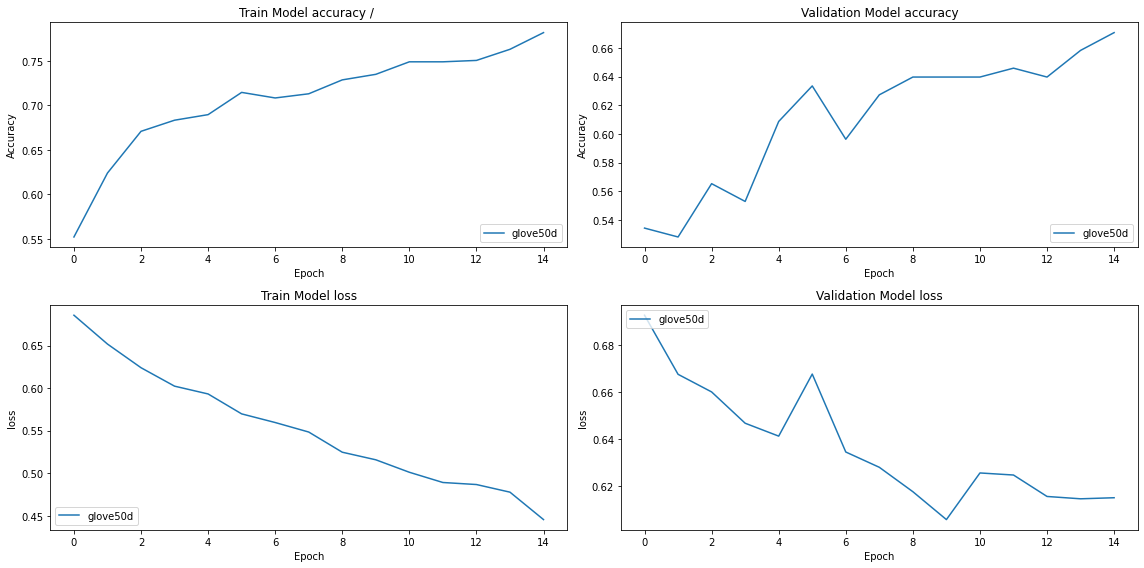

In [136]:
import matplotlib.pyplot as plt

result=load('P7-training/model_info_1.history.joblib', mmap_mode='r')

plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(2, 2)

# Plot training & validation accuracy values
axes[0,0].plot(result['accuracy'])
axes[0,0].set_title('Train Model accuracy / ')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].legend(['glove50d'], loc='lower right')

axes[0,1].plot(result['val_accuracy'])
axes[0,1].set_title('Validation Model accuracy')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].legend(['glove50d'], loc='lower right')

axes[1,0].plot(result['loss'])
axes[1,0].set_title('Train Model loss')
axes[1,0].set_ylabel('loss')
axes[1,0].set_xlabel('Epoch')
axes[1,0].legend(['glove50d'], loc='lower left')

axes[1,1].plot(result['val_loss'])
axes[1,1].set_title('Validation Model loss')
axes[1,1].set_ylabel('loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].legend(['glove50d'], loc='upper left')

plt.show()

## 17-b sortie de l output de l'entrianement du LSTM sur le cloud

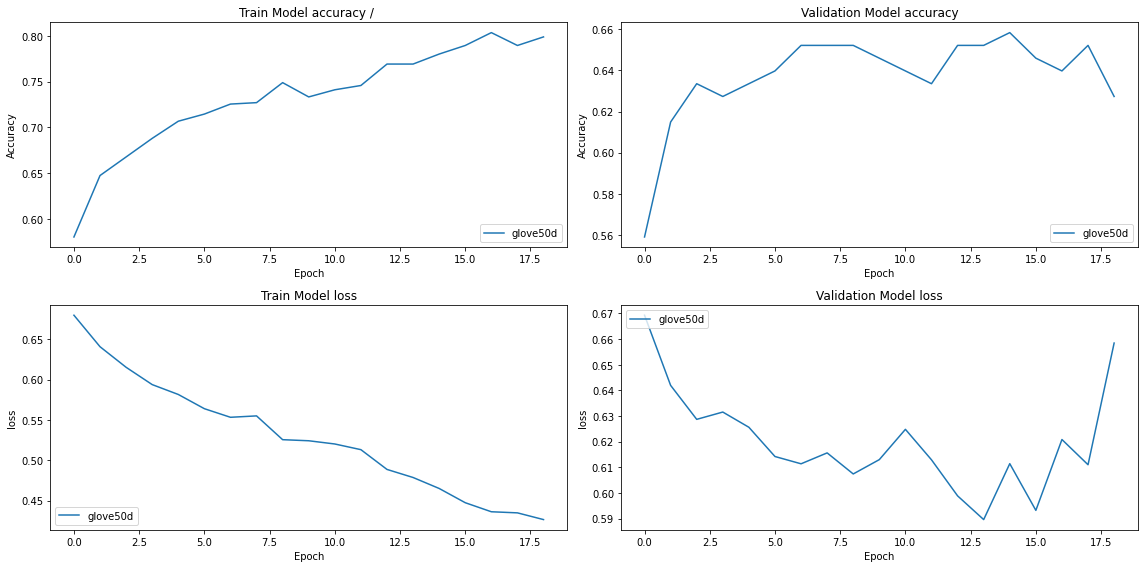

In [132]:
import matplotlib.pyplot as plt

result=load('P7-training/model_info_2.history.joblib', mmap_mode='r')

plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(2, 2)

# Plot training & validation accuracy values
axes[0,0].plot(result['accuracy'])
axes[0,0].set_title('Train Model accuracy / ')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].legend(['glove50d'], loc='lower right')

axes[0,1].plot(result['val_accuracy'])
axes[0,1].set_title('Validation Model accuracy')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].legend(['glove50d'], loc='lower right')

axes[1,0].plot(result['loss'])
axes[1,0].set_title('Train Model loss')
axes[1,0].set_ylabel('loss')
axes[1,0].set_xlabel('Epoch')
axes[1,0].legend(['glove50d'], loc='lower left')

axes[1,1].plot(result['val_loss'])
axes[1,1].set_title('Validation Model loss')
axes[1,1].set_ylabel('loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].legend(['glove50d'], loc='upper left')

plt.show()